In [1]:
using FluPredictibility, FluPredictibility.BioTools, FluPredictibility.TreeTools
using Plots
using BioSequences
using StatsBase, Dates, Measures, DataStructures, Random, 
    Statistics, DelimitedFiles, LaTeXStrings, DataFrames
Flu = FluPredictibility
pyplot()

┌ Info: Precompiling FluPredictibility [82171f4a-8572-11ea-04d1-2bb9959a1fa8]
└ @ Base loading.jl:1260


Plots.PyPlotBackend()

In [23]:
lineage = "h3n2"

# Alignments
aln_ha_aa = "../alignments/aligned_$(lineage)_ha_aa.fasta"
aln_na_aa = "../alignments/aligned_$(lineage)_na_aa.fasta"

# Trees - these are based on 25 sequences per month
nwk_raw_ha = "../data/$(lineage)/trees/ha/tree_raw.nwk"
nwk_refined_ha = "../data/$(lineage)/trees/ha/tree_refined.nwk"
aamuts_ha = "../data/$(lineage)/trees/ha/aa_muts.json"

nwk_raw_na = "../data/$(lineage)/trees/na/tree_raw.nwk"
nwk_refined_na = "../data/$(lineage)/trees/na/tree_refined.nwk"
aamuts_na = "../data/$(lineage)/trees/na/aa_muts.json"

# Binary positions
binpos_ha_file = "../data/$(lineage)/binary_positions_ha.txt"
binpos_na_file = "../data/$(lineage)/binary_positions_na.txt"

# Epitope positions
path_to_epitopes = "../data/$(lineage)/epitopes/ha/"
epitope_authors = lineage=="h3n2" ? ("Koel", "Luksza", "Shih", "Wolf") : ("Canton",)

# Time binning 
binwidth = Day(30);
binspacing = Day(30);
startdate = lineage=="h3n2" ? Date(2000) : Date(2009, 06);

# Frequency binning
alphabins_ = 0.125:0.15:0.875
alphabins = [(a, 0.075) for a in alphabins_];

In [24]:
# For plots
base = 18
lfs = base # Legend font size
alfs = base # axis label font size
tfs = base # title font size
atfs = base # axis ticks font size
ga = 0.3 # grid alpha
sizes = (1200,800) # standard size for single plots
rl = 0.065 # position of the "A" or "B" label in % 
ms = 6 # marker size
ls = 6 # line size
annfs = 34
#
saveplots = true
(sf_main, sf_SM) = readdlm("../savefolders.txt")

2×1 Array{Any,2}:
 "/home/pierrebc/Documents/BaleLabo/Notes/FluPredictibility/Article/Figures"
 "/home/pierrebc/Documents/BaleLabo/Notes/FluPredictibility/Article/SM_figures"

In [25]:
function get_trajectories(fp::Flu.FluPop, ph)
    trajectories = Flu.all_trajectories(ph, keep_unfinished=false)
    trajectories = Flu.previous_state_condition(trajectories, :lost)
    Flu.get_strains!(trajectories, fp)
    return trajectories
end

get_trajectories (generic function with 1 method)

In [26]:
fp_ha = Flu.FluPop(aln_ha_aa, :aa, Flu.flu_usual_header_fields , 
    flulineage=lineage, segment="ha", ignore_read_errors=true);
fp_na = Flu.FluPop(aln_na_aa, :aa, Flu.flu_usual_header_fields , 
    flulineage=lineage, segment="na", ignore_read_errors=true);

Reading ../alignments/aligned_h3n2_ha_aa.fasta...
Read 44971 strains out of 61848. Filtered 16877. Could not read 0
Reading ../alignments/aligned_h3n2_na_aa.fasta...
Read 36293 strains out of 39312. Filtered 3019. Could not read 0


In [27]:
Flu.bin_by_date!(fp_ha, start=startdate, binwidth=binwidth, binspacing = binspacing);
Flu.bin_by_date!(fp_na, start=startdate, binwidth=binwidth, binspacing = binspacing);
ph_ha = Flu.PosEvo(fp_ha);
ph_na = Flu.PosEvo(fp_na);

In [28]:
traj_ha = get_trajectories(fp_ha, ph_ha);
traj_na = get_trajectories(fp_na, ph_na);

## LBI - HA only

In [29]:
traw_ha = read_tree(nwk_raw_ha, NodeDataType=LBIData);
Flu.get_lbi!(fp_ha, traw_ha, verbose=false);
Flu.compute_fitness!(traj_ha, fp_ha, :strains, strainfield=:lbi);
dat, dat_low, dat_high = fitness_plot(traj_ha, :lbi_fitness, alphabins);

  0.589949 seconds (1.75 M allocations: 163.149 MiB)


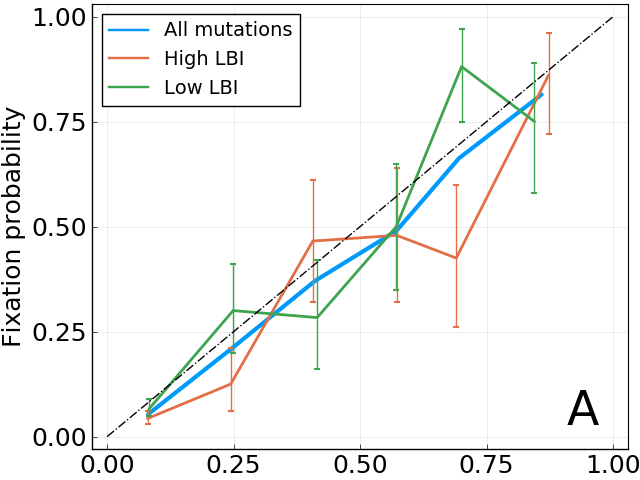

In [30]:
p = plot(size = (1200,900))
plot!(p, dat[:,1], dat[:,2], label="All mutations", line=(3))
plot!(p, dat_high[:,1], dat_high[:,2], err=dat_high[:,3], label="High LBI", line=(2), color=2)
plot!(p, dat_low[:,1], dat_low[:,2], err=dat_low[:,3], label="Low LBI", line=(2), color=3)
plot!(p, [0,1],[0,1], label="", line=(1,:black,:dashdot))

plot!(xlabel="", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs-4, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
p4_sb1 = plot(p, size=(640,480))
annotate!(0.94, 0.06, text("A",annfs))

## Epitopes - HA only

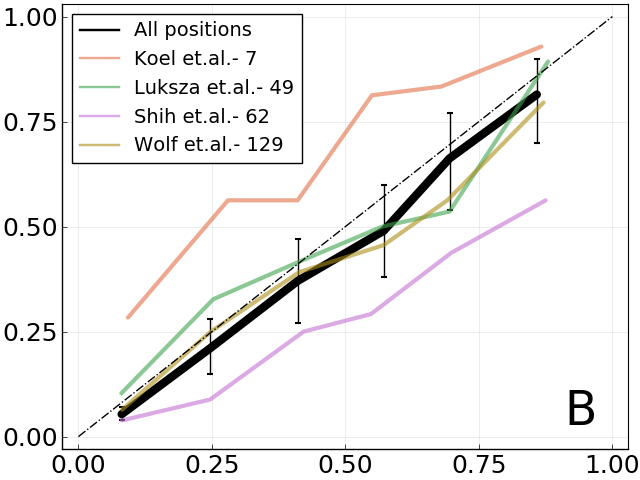

In [31]:
xf, yf, (errdown, errup) = pfix_v_freq(ph_ha, alphabins)
# 
p = plot(size = (1200,900))
plot!(p, xf, yf, err=(errdown, errup), line=(:black, 6), 
    markercolor=:black, markerstrokecolor=:black, label="All positions")
# Epitopes
for a in epitope_authors[1:end]
    pos = vec(readdlm("$(path_to_epitopes)/epitope_positions_$(lowercase(a)).txt", Int64))
    x,y = pfix_v_freq(ph_ha[pos], alphabins)
    plot!(p, x, y, line=(3), alpha=0.6, label="$a et.al.- $(length(pos))")
end
# #
plot!(p, [0,1],[0,1], label="", line=(1,:black,:dashdot))
plot!(p, xlabel="", ylabel="")
plot!(p, legendfontsize=lfs-4, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
p4_sb2 = plot(p, size=(640,480))
annotate!(0.94, 0.06, text("B",annfs))

## Binary positions - HA and NA

In [44]:
binpos_ha = vec(readdlm(binpos_ha_file, Int64));
binpos_na = vec(readdlm(binpos_na_file, Int64));

nbinpos_ha = findall(x->!in(x,binpos_ha), 1:length(ph_ha)) 
nbinpos_na = findall(x->!in(x,binpos_na), 1:length(ph_na))

ph_all = vcat(ph_ha, ph_ha);
ph_bin = vcat(ph_ha[binpos_ha], ph_na[binpos_na])
ph_nbin = vcat(ph_ha[nbinpos_ha], ph_na[nbinpos_na]);

Nbinpos = length(binpos_ha) + length(binpos_na)
Nnbinpos = length(nbinpos_ha) + length(nbinpos_na);

MethodError: MethodError: no method matching readdlm_auto(::Array{Int64,1}, ::Char, ::Type{Int64}, ::Char, ::Bool)
Closest candidates are:
  readdlm_auto(!Matched::Array{UInt8,1}, ::AbstractChar, ::Type, ::AbstractChar, ::Bool; opts...) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.4/DelimitedFiles/src/DelimitedFiles.jl:228
  readdlm_auto(!Matched::IO, ::AbstractChar, ::Type, ::AbstractChar, ::Bool; opts...) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.4/DelimitedFiles/src/DelimitedFiles.jl:230
  readdlm_auto(!Matched::AbstractString, ::AbstractChar, ::Type, ::AbstractChar, ::Bool; opts...) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.4/DelimitedFiles/src/DelimitedFiles.jl:233

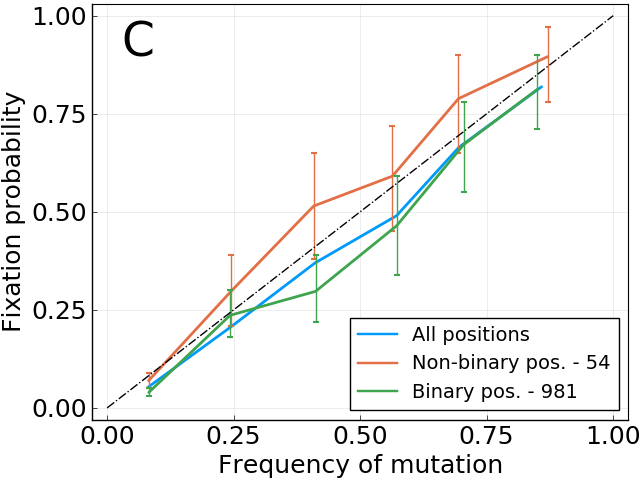

In [33]:
x_all, y_all, err_all = pfix_v_freq(ph_all, alphabins);
x_nbin, y_nbin, err_nbin = pfix_v_freq(ph_nbin, alphabins);
x_bin, y_bin, err_bin = pfix_v_freq(ph_bin, alphabins);

#
p = plot(size = (1280,960))
plot!(p, x_all, y_all, label="All positions", line=(2))
plot!(p, x_nbin, y_nbin, err=err_nbin, label="Non-binary pos. - $(Nnbinpos)", line=(2))
plot!(p, x_bin, y_bin, err=err_bin, label="Binary pos. - $(Nbinpos)", line=(2))
plot!(p, [0,1],[0,1], label="", line=(1,:black,:dashdot))
plot!(xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs-4, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
#
p4_sb3 = plot(p, size=(640, 480), legend=:bottomright)
annotate!(0.06, 0.93, text("C",annfs))


## Number of times in tree - HA and NA

In [34]:
tref_ha = read_tree(nwk_refined_ha);
Flu.read_mutations!(tref_ha, aamuts_ha);
for traj in traj_ha
    Flu.compute_tree_spread!(traj, tref_ha, fp_ha)
end
Flu.compute_fitness!(traj_ha, fp_ha, :treespread,)

# 
tref_na = read_tree(nwk_refined_na);
Flu.read_mutations!(tref_na, aamuts_na, lineage=lineage, segment="na");
for traj in traj_na
    Flu.compute_tree_spread!(traj, tref_na, fp_na)
end
Flu.compute_fitness!(traj_na, fp_na, :treespread,)

  0.480555 seconds (1.08 M allocations: 107.633 MiB, 6.40% gc time)
  0.079869 seconds (301.64 k allocations: 40.705 MiB)


In [35]:
dat, dat_low, dat_high = fitness_plot(vcat(traj_ha, traj_ha),
    :treespread_fitness, alphabins);

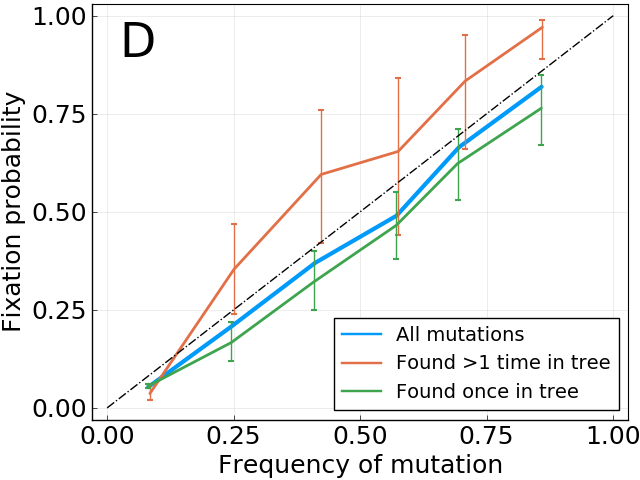

In [36]:
p = plot(size = (1280,960))
plot!(p, dat[:,1], dat[:,2], label="All mutations", line=(3))
plot!(p, dat_high[:,1], dat_high[:,2], err=dat_high[:,3], label="Found >1 time in tree", line=(2))
plot!(p, dat_low[:,1], dat_low[:,2], err=dat_low[:,3], label="Found once in tree", line=(2))
plot!(p, [0,1],[0,1], label="", line=(1,:black,:dashdot))

plot!(xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs-4, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
p4_sb4 = plot(p, size=(640, 480), legend=:bottomright)
annotate!(0.06, 0.93, text("D",annfs))

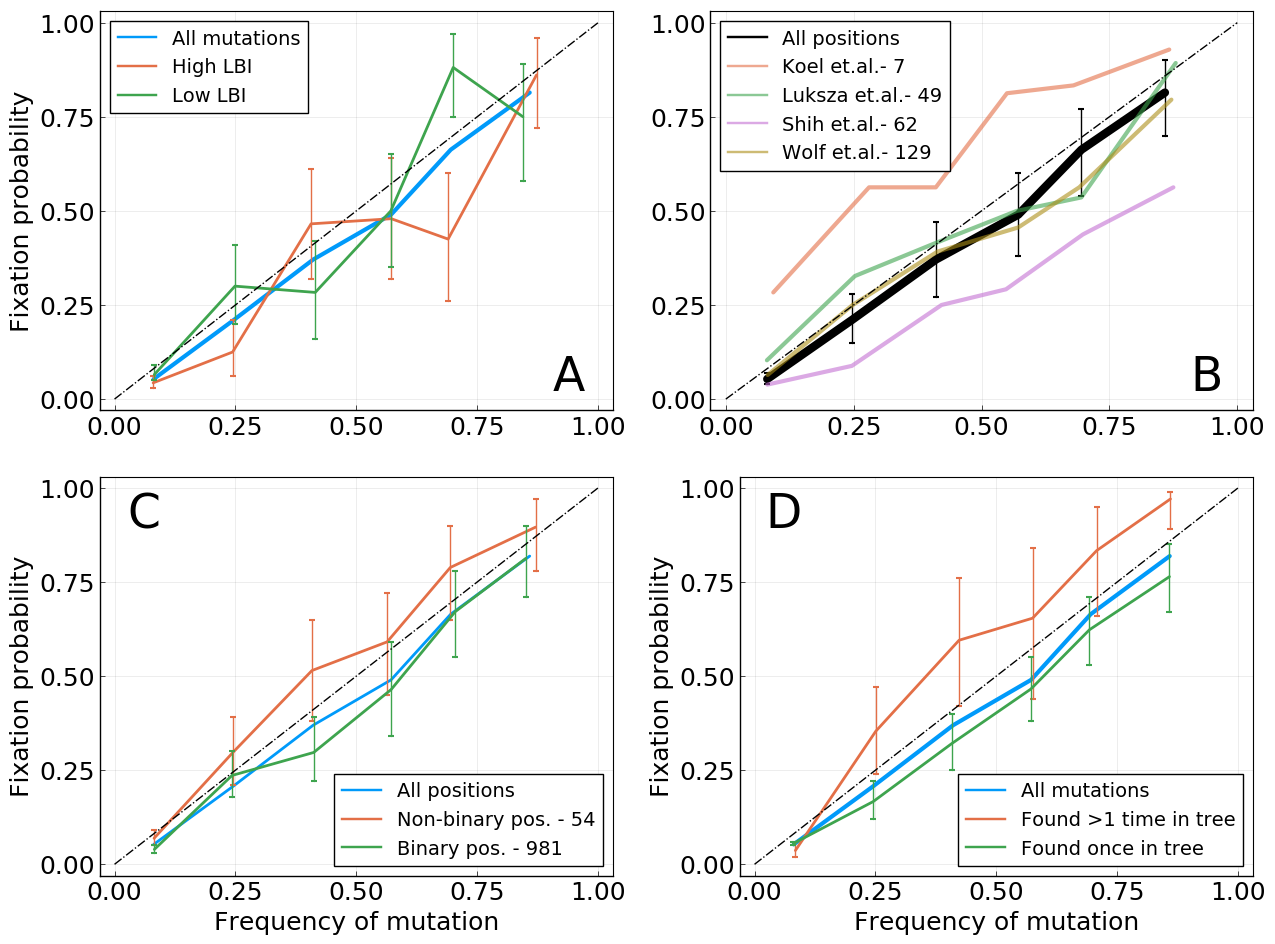

In [42]:
p = plot(p4_sb1, p4_sb2, p4_sb3, p4_sb4, layout = grid(2,2), size=(1280,960), margin= 5mm)
saveplots && savefig(p, "$(sf_main)/Panel4.png")
saveplots && savefig(p, "$(sf_SM)/pfix_v_freq_strat_$(lineage).png")

## Geographic spread - HA and NA

In [38]:
Flu.get_regions!(traj_ha, fp_ha)
Flu.compute_fitness!(traj_ha, fp_ha, :region);

Flu.get_regions!(traj_na, fp_na)
Flu.compute_fitness!(traj_na, fp_na, :region);
#
dat, dat_low, dat_high = fitness_plot(vcat(traj_ha, traj_na), :region_fitness, alphabins);

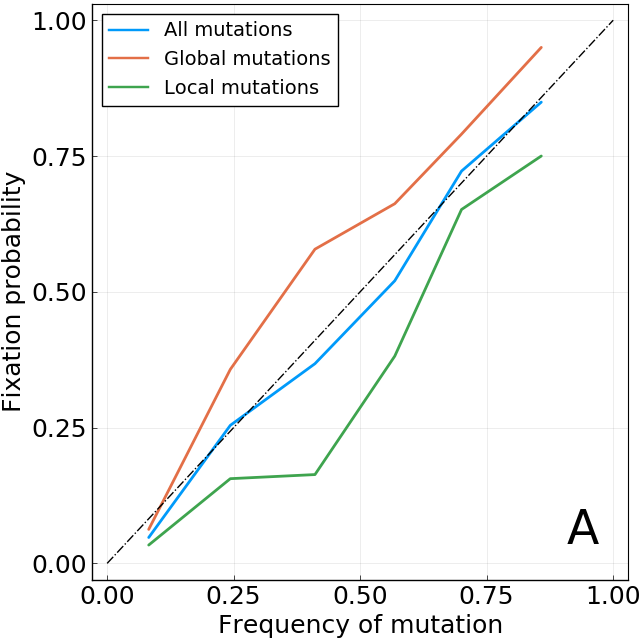

In [39]:
p = plot(size = (1200,900))
plot!(p, dat[:,1], dat[:,2], label="All mutations", line=(2))
plot!(p, dat[:,1], dat_high[:,2], label="Global mutations", line=(2))
plot!(p, dat[:,1], dat_low[:,2], label="Local mutations", line=(2))
plot!(p, [0,1],[0,1], label="", line=(1,:black,:dashdot))

plot!(xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs-4, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
p_sm2_sb1 = plot(p, size=(640,640))
annotate!(0.94, 0.06, text("A",annfs))

## Age of trajectory - HA and NA

In [40]:
Flu.compute_fitness!(traj_ha, fp_ha, :date)
Flu.compute_fitness!(traj_na, fp_na, :date)
#
dat, dat_low, dat_high = fitness_plot(vcat(traj_ha, traj_na), :date_fitness, alphabins);

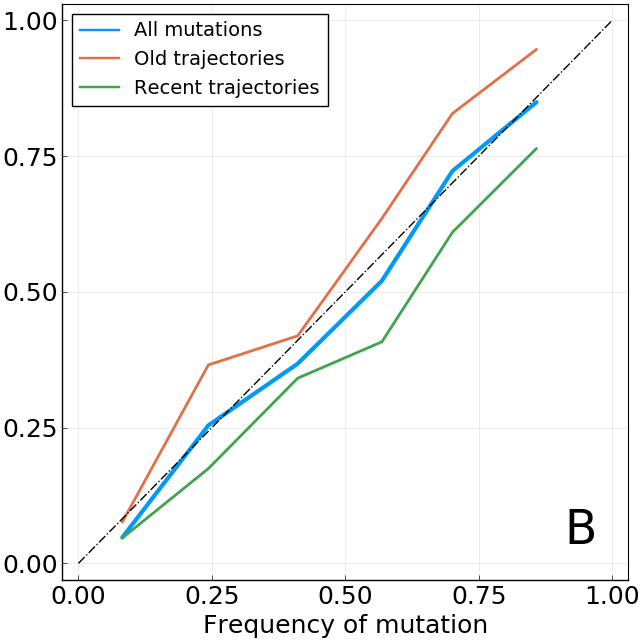

In [41]:
p = plot(size = (1200,900))
plot!(p, dat[:,1], dat[:,2], label="All mutations", line=(3))
plot!(p, dat[:,1], dat_high[:,2], label="Old trajectories", line=(2))
plot!(p, dat[:,1], dat_low[:,2], label="Recent trajectories", line=(2))
plot!(p, [0,1],[0,1], label="", line=(1,:black,:dashdot))

plot!(xlabel="Frequency of mutation", ylabel="")
plot!(p, legendfontsize=lfs-4, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
p_sm2_sb2 = plot(p, size=(640, 640), legend=:topleft)
annotate!(0.94, 0.06, text("B",annfs))

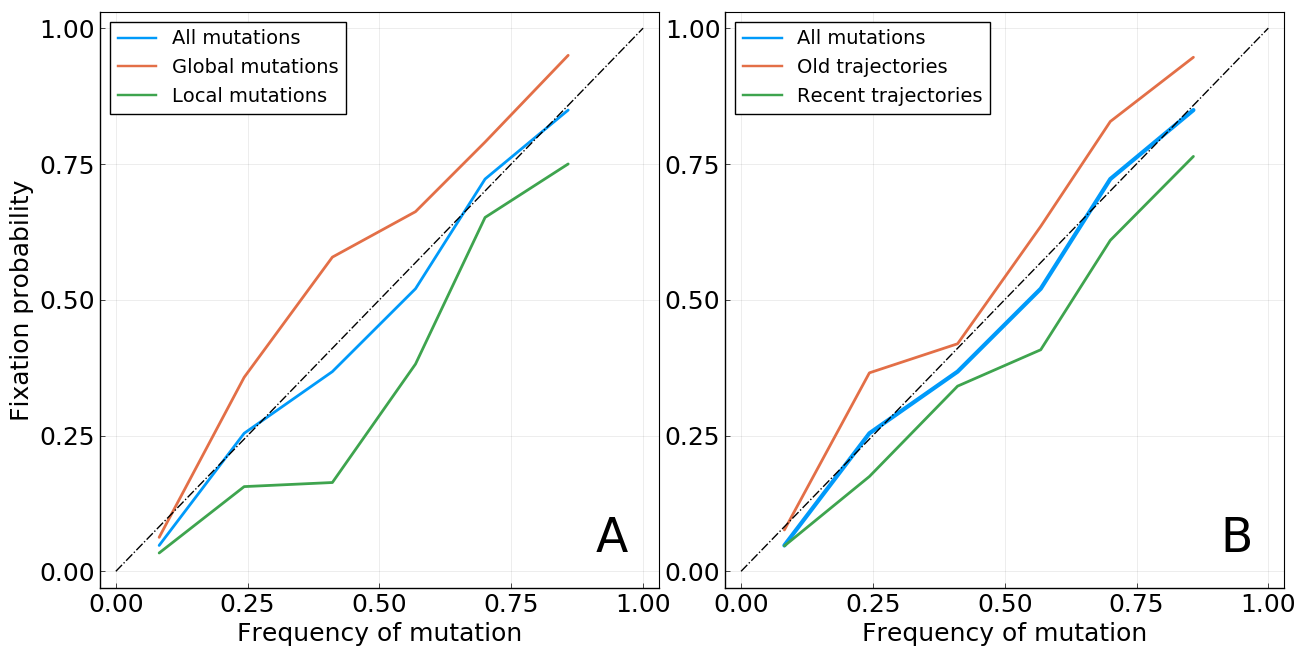

In [43]:
p_sm2 = plot(p_sm2_sb1, p_sm2_sb2, layout=grid(1,2), size=(1280, 640))
saveplots && savefig("$(sf_SM)/geospread_and_time_$(lineage).png")